## Imports


In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics

# import inspect
from os import path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import struct
import time

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, Binarizer


import pandas as pd
import numpy as np
import pickle

##  Functions

In [2]:
# function that calculates the r squared error
def r_squared_error(y_real, y_est):
    residuals = y_real - y_est
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_real-np.mean(y_real))**2)
    return (1 - (ss_res / ss_tot))

# function that plot a boxplot for each column in a dataframe (the Y column needs to be the last in the frame)
def boxplot(data,y_value):

    categorical = data.columns.tolist()
    categorical = categorical[:-1]

    fig, ax = plt.subplots(len(categorical), 1, figsize=(15, 100))

    i=0

    for var, subplot in zip(categorical, ax.flatten()):
        sns.boxplot(x=var, y=y_value, data=data, ax=subplot, linewidth=2.5)
        ax[i].tick_params(axis='x',labelsize=15,labelrotation=30)
        ax[i].tick_params(axis='y',labelsize=15)
        ax[i].set_title(f'{y_value} vs {var}',size=18)
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')
        i+=1

    return plt.show()

# function that devolves a dataframe that includes r squared and MSE
def model_df(model,y,y_pred):

    result = pd.DataFrame({
                             'Model'     :[model],
                             'R Squared' :[round(r_squared_error(y,y_pred),3)],
                             'MSE'       :[round(np.sqrt(mean_squared_error(y,y_pred)),3)],
                              })
    return result

# funtion that creates and uses a label enconder wiht a particular set of data
# parameters: objective(the values that is needed to convert) / process("transform" to encode and "inverse" to desencode)
def label_encoder(objective,process):

    filename = 'LabelEncoder.sav'
    
    if path.exists(filename)==0:
    
        lbl_enc = LabelEncoder()
        
        lbl_enc.fit(objective)
    
        pickle.dump(lbl_enc, open(filename, 'wb'))
        
        result = 'the model has been trained and stored'
        
        return result   
    
    else:
        
        lbl_enc = pickle.load(open(filename, 'rb'))
        
        
    if process=='transform':
        
        result = lbl_enc.transform(objective)
        
    elif process=='inverse':
            
        result = lbl_enc.inverse_transform(objective)
        
    else:
            
        result = 'Put a valid value for process'
    
    return result

# function that devolves a value depending of a range declared in a series
def range_imc(target, value):

    for v in range(len(value)):

            if target < value[v]:

                return value.index[v]
            
                break

## Data


In [3]:
# reading the data and storing it into a dataframe
data = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')
data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
# data general information
data.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


## Data Transformation

In [5]:
# calculing the IMC, that will be our target for our regression model
data['IMC'] = data['Weight']/data['Height']**2
data_regr   = data.drop(columns=['NObeyesdad', 'Weight'])

In [6]:
# training the label encoder
label_encoder(data['NObeyesdad'],'transform')

array([1, 1, 1, ..., 4, 4, 4])

In [7]:
# changing the dataframe to convert the object variables into dummies
data_regr   = pd.concat([data_regr.select_dtypes(exclude=['object']),
                         pd.get_dummies(data_regr.select_dtypes(include=['object']))],
                         axis=1)

# creating the classification dataframe with the dummies variables and the target labeled
data_clas   = pd.concat([data_regr.select_dtypes(exclude=['object']).drop(columns=['IMC']),
                         pd.DataFrame(label_encoder(data['NObeyesdad'],'transform'), columns=['NObeyesdad'])],
                         axis=1)

In [8]:
# showing the results
data_regr.head()

,Age,Height,FCVC,NCP,CH2O,FAF,TUE,IMC,Gender_Female,Gender_Male,...,SCC_yes,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,21.0,1.62,2.0,3.0,2.0,0.0,1.0,24.386526,1,0,...,0,0,0,0,1,0,0,0,1,0
1,21.0,1.52,3.0,3.0,3.0,3.0,0.0,24.238227,1,0,...,1,0,0,1,0,0,0,0,1,0
2,23.0,1.80,2.0,3.0,2.0,2.0,1.0,23.765432,0,1,...,0,0,1,0,0,0,0,0,1,0
3,27.0,1.80,3.0,3.0,2.0,2.0,0.0,26.851852,0,1,...,0,0,1,0,0,0,0,0,0,1
4,22.0,1.78,2.0,1.0,2.0,0.0,0.0,28.342381,0,1,...,0,0,0,1,0,0,0,0,1,0


In [9]:
# showing the results
data_clas.head()

,Age,Height,FCVC,NCP,CH2O,FAF,TUE,Gender_Female,Gender_Male,family_history_with_overweight_no,...,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,NObeyesdad
0,21.0,1.62,2.0,3.0,2.0,0.0,1.0,1,0,0,...,0,0,0,1,0,0,0,1,0,1
1,21.0,1.52,3.0,3.0,3.0,3.0,0.0,1,0,0,...,0,0,1,0,0,0,0,1,0,1
2,23.0,1.80,2.0,3.0,2.0,2.0,1.0,0,1,0,...,0,1,0,0,0,0,0,1,0,1
3,27.0,1.80,3.0,3.0,2.0,2.0,0.0,0,1,1,...,0,1,0,0,0,0,0,0,1,5
4,22.0,1.78,2.0,1.0,2.0,0.0,0.0,0,1,1,...,0,0,1,0,0,0,0,1,0,6


## Data Exploration

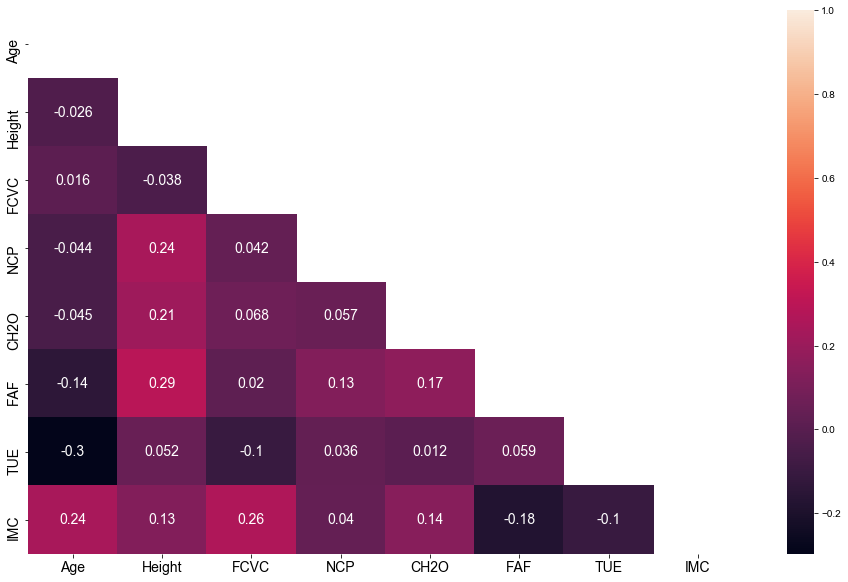

In [10]:
# correlation plot of the values from the table
mask = np.zeros_like(data_regr.iloc[:, 0:8].corr())
triangle_indices = np.triu_indices_from(mask)
mask[triangle_indices] = True

plt.figure(figsize=(16,10))
sns.heatmap(data_regr.iloc[:, 0:8].corr(),mask=mask, annot=True, annot_kws={"size": 14})
sns.set_style('white')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

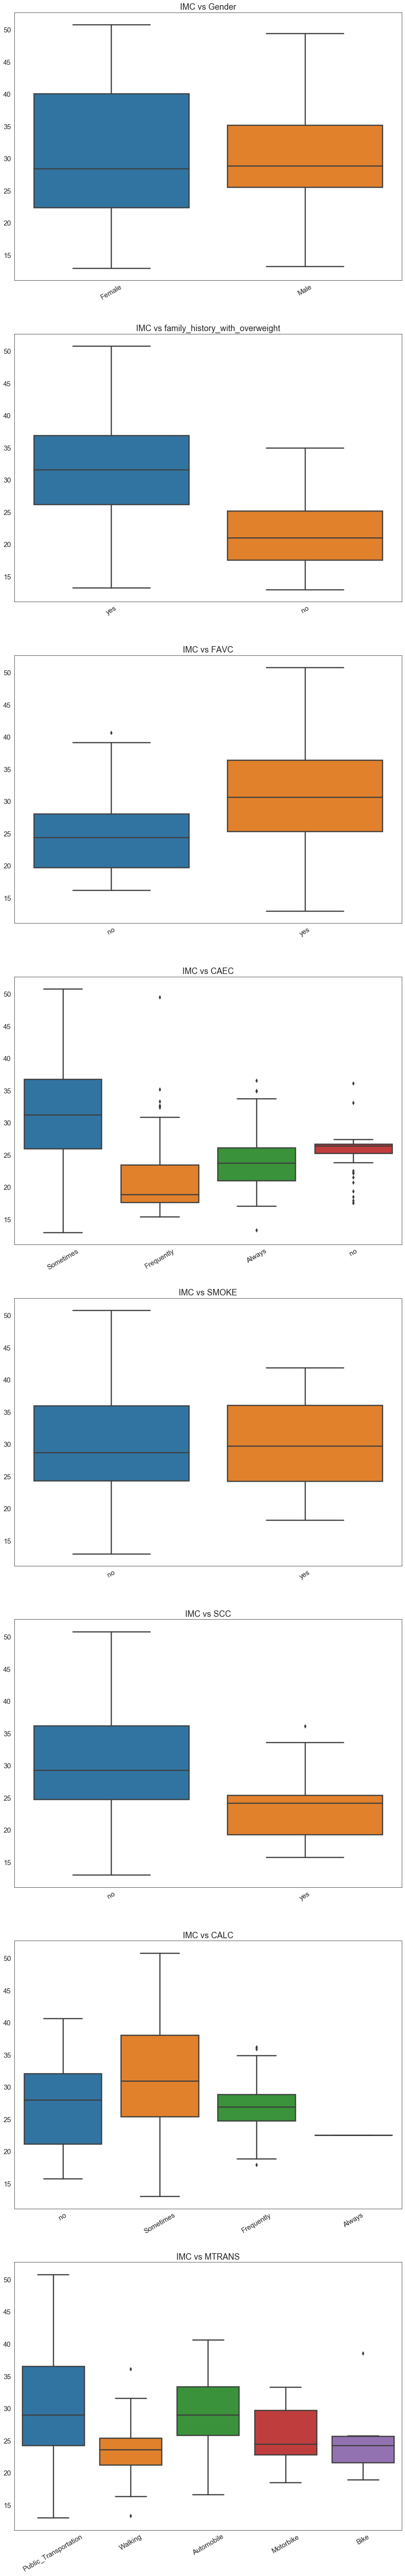

In [11]:
# making a boxplot for each categorical column in the frame 
data_cat = data['Weight']/data['Height']**2
data_cat = pd.concat([data.select_dtypes(include=['object']).drop(columns=['NObeyesdad']),data_cat],axis=1)
data_cat = data_cat.rename(columns={0: "IMC"})

boxplot(data_cat,'IMC')

## Batching

In [12]:
# creating test and train sets 
X_train, X_test, y_train, y_test = train_test_split(data_regr.drop(columns=['IMC']),data_regr['IMC'],
                                                    train_size=0.90, random_state=42)

## Training

In [13]:
# models
lr   = LinearRegression()
dtr  = DecisionTreeRegressor()
rfr  = RandomForestRegressor()
xgbr = XGBRegressor()
en   = ElasticNet()

## Linear Regression

In [14]:
# model training and parameter tuning
parameters = {'normalize': [False, True]}

lr_grid = GridSearchCV(lr,
                       parameters,
                       cv = 4,
                       n_jobs = 4,
                       verbose=True)

lr_grid.fit(X_train,y_train)

Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:    2.1s finished


GridSearchCV(cv=4, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=4,
             param_grid={'normalize': [False, True]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=True)

In [15]:
lr_grid.best_params_

{'normalize': False}

In [16]:
# creating a dataframe with the result of the training
model_lr = model_df('Linear Regression',y_test,lr_grid.predict(X_test))

model_lr.head()

,Model,R Squared,MSE
0,Linear Regression,0.445,6.166


## Decision Tree

In [17]:
# model training and parameter tuning
parameters = {'max_depth': [5, 6, 7],
              'min_samples_leaf': [4,2]}

dtr_grid = GridSearchCV(dtr,
                        parameters,
                        cv = 4,
                        n_jobs = 4,
                        verbose=True)

dtr_grid.fit(X_train,y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed:    0.1s finished


GridSearchCV(cv=4, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=4,
             param_grid={'max_depth': [5, 6, 7], 'min_samples_leaf': [4, 2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
    

In [18]:
dtr_grid.best_params_

{'max_depth': 7, 'min_samples_leaf': 4}

In [19]:
# creating a dataframe with the result of the training
model_dtr = model_df('Decision Tree',y_test,dtr_grid.predict(X_test))

model_dtr.head()

,Model,R Squared,MSE
0,Decision Tree,0.751,4.134


## Random Forest

In [20]:
# model training and parameter tuning
parameters = {'max_depth': [9, 12, 15],
              'n_estimators': [50,100,150,200]}

rf_grid = GridSearchCV(rfr,
                       parameters,
                       cv = 4,
                       n_jobs = 4,
                       verbose=True)

rf_grid.fit(X_train,y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=4)]: Done  48 out of  48 | elapsed:   17.3s finished


GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [21]:
rf_grid.best_params_

{'max_depth': 15, 'n_estimators': 150}

In [74]:
# creating a dataframe with the result of the training
model_rf = model_df('Random Forest',y_test,rf_grid.predict(X_test))

model_rf.head()

,Model,R Squared,MSE
0,Random Forest,-219.954,27.859


## XGBR

In [23]:
# model training and parameter tuning
parameters = {'objective':['reg:squarederror'],
              'learning_rate': [0.03, 0.05, .07], 
              'max_depth': [5, 6, 7],
              'min_child_weight': [4,3],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [200,500,700]}

xgb_grid = GridSearchCV(xgbr,
                        parameters,
                        cv = 4,
                        n_jobs = 4,
                        verbose=True)

xgb_grid.fit(X_train,y_train)

Fitting 4 folds for each of 54 candidates, totalling 216 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   20.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 216 out of 216 | elapsed:  1.8min finished


GridSearchCV(cv=4, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.03, 0.05, 0.07],
                         'm

In [24]:
xgb_grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.03,
 'max_depth': 7,
 'min_child_weight': 3,
 'n_estimators': 700,
 'objective': 'reg:squarederror',
 'subsample': 0.7}

In [25]:
# creating a dataframe with the result of the training
model_xgb = model_df('XGBR',y_test,xgb_grid.predict(X_test))

model_xgb.head()

,Model,R Squared,MSE
0,XGBR,0.891,2.737


## ElasticNet

In [26]:
# model training and parameter tuning
parameters = {"l1_ratio":[0,0.25,.5,.75,1],
              "alpha":[0.5,1,2],
              "max_iter":[2000]}

en_grid = GridSearchCV( en,
                        parameters,
                        cv = 4,
                        n_jobs = 4,
                        verbose=True)

en_grid.fit(X_train,y_train)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    1.0s finished


GridSearchCV(cv=4, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=4,
             param_grid={'alpha': [0.5, 1, 2],
                         'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
                         'max_iter': [2000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=True)

In [27]:
en_grid.best_params_

{'alpha': 0.5, 'l1_ratio': 1, 'max_iter': 2000}

In [28]:
# creating a dataframe with the result of the training
model_en = model_df('ElasticNet',y_test,en_grid.predict(X_test))

model_en.head()

,Model,R Squared,MSE
0,ElasticNet,0.373,6.556


## Training Results and Analysis

In [29]:
# creating a dataframe with all the traing results
Training  =  pd.concat([model_lr ,
                        model_dtr,
                        model_rf ,
                        model_xgb,
                        model_en],
                        axis=0)
Training.head()

,Model,R Squared,MSE
0,Linear Regression,0.445,6.166
0,Decision Tree,0.751,4.134
0,Random Forest,0.878,2.896
0,XGBR,0.891,2.737
0,ElasticNet,0.373,6.556


Apparently the best model result to be the XG boost, having the highest R squared and the lowest MSE. In the next part we are going to analyse the predicted values and the residuals, to assure that the models perform well.

In [30]:
# creating the series of the predictions and metrics

# xg boost
y_pred_xgb          = pd.Series(xgb_grid.predict(X_test)) 

resid_pred_xgb      = y_test - y_pred_xgb 

corr_pred_xgb       = round(y_test.corr(y_pred_xgb), 2)

resid_pred_mean_xgb = round(resid_pred_xgb.mean(),2)

resid_pred_skew_xgb = round(resid_pred_xgb.skew(),2)

# random forest
y_pred_rf          = pd.Series(rf_grid.predict(X_test)) 

resid_pred_rf      = y_test - y_pred_rf 

corr_pred_rf       = round(y_test.corr(y_pred_rf), 2)

resid_pred_mean_rf = round(resid_pred_rf.mean(),2)

resid_pred_skew_rf = round(resid_pred_rf.skew(),2)

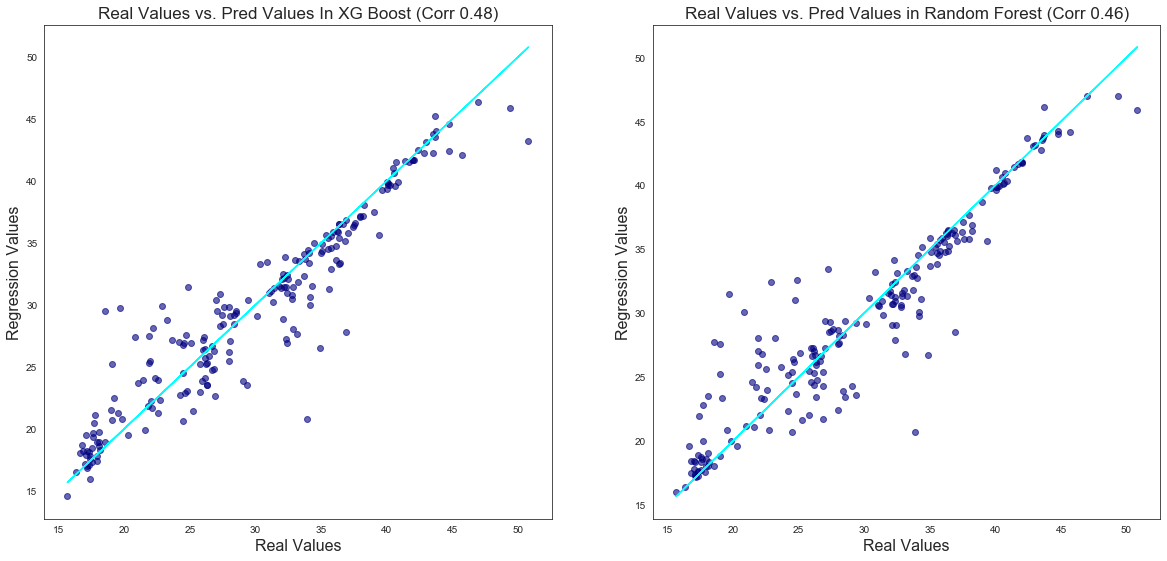

In [31]:
# ploting the real and the predicted values 

plt.figure(figsize=(20, 20))

plt.subplot(221)

plt.scatter(x=y_test, y=y_pred_xgb, c='navy', alpha=0.6)
plt.plot(y_test, y_test, color='cyan')

plt.xlabel('Real Values', fontsize=16)
plt.ylabel('Regression Values', fontsize=16)
plt.title(f'Real Values vs. Pred Values In XG Boost (Corr {corr_pred_xgb})', fontsize=17)

plt.subplot(222)

plt.scatter(x=y_test, y=y_pred_rf, c='navy', alpha=0.6)
plt.plot(y_test, y_test, color='cyan')

plt.xlabel('Real Values', fontsize=16)
plt.ylabel('Regression Values', fontsize=16)
plt.title(f'Real Values vs. Pred Values in Random Forest (Corr {corr_pred_rf})', fontsize=17)

plt.show()

C:\Users\Alexis\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Alexis\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


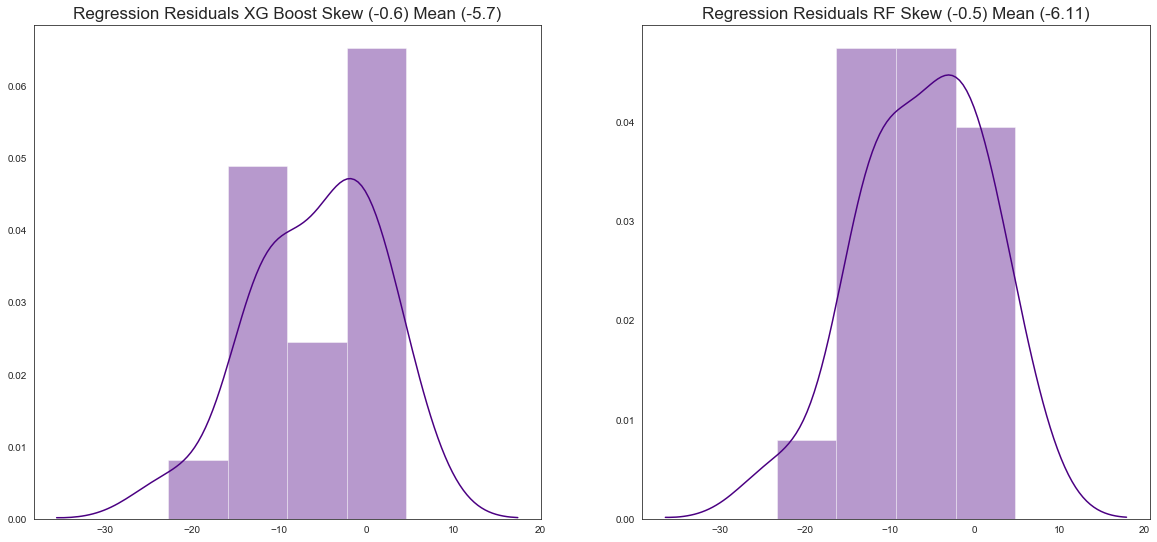

In [32]:
# ploting the frecuency of the residuals
plt.figure(figsize=(20, 20))

plt.subplot(221)

sns.distplot(resid_pred_xgb, color='indigo')

plt.title(f'Regression Residuals XG Boost Skew ({resid_pred_skew_xgb}) Mean ({resid_pred_mean_xgb})', fontsize=17)

plt.subplot(222)

sns.distplot(resid_pred_rf, color='indigo')

plt.title(f'Regression Residuals RF Skew ({resid_pred_skew_rf}) Mean ({resid_pred_mean_rf})', fontsize=17)


plt.show()

# Clasification

## Batching

In [70]:
# creating test and train sets 
X_train, X_test, y_train, y_test = train_test_split(data_clas.drop(columns=['NObeyesdad']),data_clas['NObeyesdad'],
                                                    train_size=0.90, random_state=42)

## Random Forest

In [34]:
# the pipeline witch the starter scalers and models
pipe_fore    = Pipeline([
                         ('dt', RandomForestClassifier())
                          ])

# the parameters and diferent models/scalers that will be used
pargrid_fore = [
                {'dt':[RandomForestClassifier()],
                 'dt__bootstrap': [True,False],
                 'dt__max_depth': [150, 200],
                 'dt__min_samples_leaf': [2, 3],
                 'dt__n_estimators': [ 800, 1000]}
                  ]

In [35]:
# model training and the time that is running
t0 = time.time()

CV_fore = KFold(n_splits=4)

GS_fore = GridSearchCV(estimator = pipe_fore,
                  param_grid = pargrid_fore,
                  cv=CV_fore,
                  n_jobs= -3)

GS_fore.fit(X_train,y_train)

run_time_fore = time.time() - t0

In [36]:
# best paramameters specified in the param_grid 
GS_fore.best_params_

{'dt': RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=150, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=2, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=800,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
 'dt__bootstrap': False,
 'dt__max_depth': 150,
 'dt__min_samples_leaf': 2,
 'dt__n_estimators': 800}

In [37]:
# use the model to make predictions with the test data
y_pred_fore = GS_fore.predict(X_test)

# how did our model perform
count_misclassified_fore = (y_test != y_pred_fore).sum()
accuracy_fore            = metrics.accuracy_score(y_test, y_pred_fore)

# print the results
print('Misclassified samples: {}'.format(count_misclassified_fore))
print('Accuracy: {:.2f}'.format(accuracy_fore))

Misclassified samples: 26
Accuracy: 0.88


## XGRB

In [38]:
# the pipeline witch the starter scalers and models
pipe_xgbr = Pipeline([('xgbrg', XGBClassifier())])

# the parameters and diferent models/scalers that will be used
pargrid_xgbr = [
                 {'xgbrg':[XGBClassifier()],
                 'xgbrg__objective': ['multi:softmax'],
                 'xgbrg__num_class': [7],
                 'xgbrg__max_depth': [10, 15, 20],
                 }
                  ]

In [39]:
# model training and the time that is running

CV_xgbr = KFold(n_splits=4)

GS_xgbr = GridSearchCV(estimator = pipe_xgbr,
                  param_grid = pargrid_xgbr,
                  cv=CV_xgbr,
                  n_jobs= -3)

GS_xgbr.fit(X_train,y_train.astype(np.float64))

GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('xgbrg',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0,
                                                      learning_rate=0.1,
                                                      max_delta_step=0,
                                                      max_depth=3,
                                                      min_child_weight=1,
                                                      missing=None,
                         

In [40]:
# best paramameters specified in the param_grid 
GS_xgbr.best_params_

{'xgbrg': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               learning_rate=0.1, max_delta_step=0, max_depth=10,
               min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
               nthread=None, num_class=7, objective='multi:softmax',
               random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
               seed=None, silent=None, subsample=1, verbosity=1),
 'xgbrg__max_depth': 10,
 'xgbrg__num_class': 7,
 'xgbrg__objective': 'multi:softmax'}

In [41]:
# use the model to make predictions with the test data
y_pred_xgbr = GS_xgbr.predict(X_test)

# how did our model perform
count_misclassified_xgbr = (y_test.astype(np.float64) != y_pred_xgbr).sum()
accuracy_xgbr = metrics.accuracy_score(y_test.astype(np.float64), y_pred_xgbr)

# print the results
print('Misclassified samples: {}'.format(count_misclassified_xgbr))
print('Accuracy: {:.2f}'.format(accuracy_xgbr))

Misclassified samples: 33
Accuracy: 0.84


# Final Results

Now the idea is compare the two forms of prediction and see wich one performs better 

In [46]:
# first whe need to find wich intervals of IMC correspond to each NObeyesdad
imc_range =  pd.concat([data[['NObeyesdad','IMC']].rename(columns={'IMC': "min"}).groupby(['NObeyesdad']).min()  ,
                        data[['NObeyesdad','IMC']].rename(columns={'IMC': "max"}).groupby(['NObeyesdad']).max()  ,
                        data[['NObeyesdad','IMC']].rename(columns={'IMC': "mean"}).groupby(['NObeyesdad']).mean()],
                        axis=1)

imc_range = imc_range.sort_values(by=['mean'])

In [47]:
# showing the results
imc_range

,min,max,mean
NObeyesdad,,,
Insufficient_Weight,12.998685,19.082206,17.404245
Normal_Weight,18.491124,24.913495,22.014147
Overweight_Level_I,22.826739,28.769607,25.990772
Overweight_Level_II,25.713513,30.362877,28.215232
Obesity_Type_I,29.911958,35.171095,32.255636
Obesity_Type_II,34.048509,39.786652,36.723424
Obesity_Type_III,36.774400,50.811753,42.273746


In [134]:
# creating the new frame
results    = pd.concat([pd.DataFrame(rf_grid.predict(X_test), columns=['IMC']),
                        pd.DataFrame(label_encoder(GS_fore.predict(X_test),'inverse'), columns=['class_NObeyesdad']) ,
                        pd.DataFrame(label_encoder(y_test,'inverse'), columns=['NObeyesdad'])],
                        axis=1)

# matching IMC with their corresponding NObeyesdad
results['regr_NObeyesdad'] = results['IMC'].apply(lambda x: range_imc(x,imc_range['max']))

In [135]:
# creating a column per each model that calculates if the prediction is false
results['regr_false'] = (results['regr_NObeyesdad'] != results['NObeyesdad'])
results['class_false'] = (results['class_NObeyesdad'] != results['NObeyesdad'])

In [137]:
# cheking the accuracy of each model 
accuracy_regr = metrics.accuracy_score(results['regr_NObeyesdad'], results['NObeyesdad'])
accuracy_class = metrics.accuracy_score(results['class_NObeyesdad'], results['NObeyesdad'])

print('Accuracy of regression: {:.2f}'.format(accuracy_regr))
print('Accuracy of clasification: {:.2f}'.format(accuracy_class))

Accuracy of regression: 0.68
Accuracy of clasification: 0.88


In [138]:
results

,IMC,class_NObeyesdad,NObeyesdad,regr_NObeyesdad,regr_false,class_false
0,21.952320,Insufficient_Weight,Insufficient_Weight,Normal_Weight,True,False
1,41.816010,Obesity_Type_III,Obesity_Type_III,Obesity_Type_III,False,False
2,18.727982,Insufficient_Weight,Insufficient_Weight,Insufficient_Weight,False,False
3,18.320343,Insufficient_Weight,Insufficient_Weight,Insufficient_Weight,False,False
4,25.140791,Normal_Weight,Normal_Weight,Overweight_Level_I,True,False
...,...,...,...,...,...,...
207,26.188955,Overweight_Level_I,Overweight_Level_I,Overweight_Level_I,False,False
208,26.776839,Obesity_Type_I,Obesity_Type_I,Overweight_Level_I,True,False
209,45.915618,Obesity_Type_III,Obesity_Type_III,Obesity_Type_III,False,False
210,25.276733,Overweight_Level_I,Overweight_Level_I,Overweight_Level_I,False,False


In [144]:
# creting a dataframe with the sum of false prediction per class
class_false = results.drop(columns=['IMC','class_NObeyesdad','regr_NObeyesdad']).groupby(['NObeyesdad']).sum()

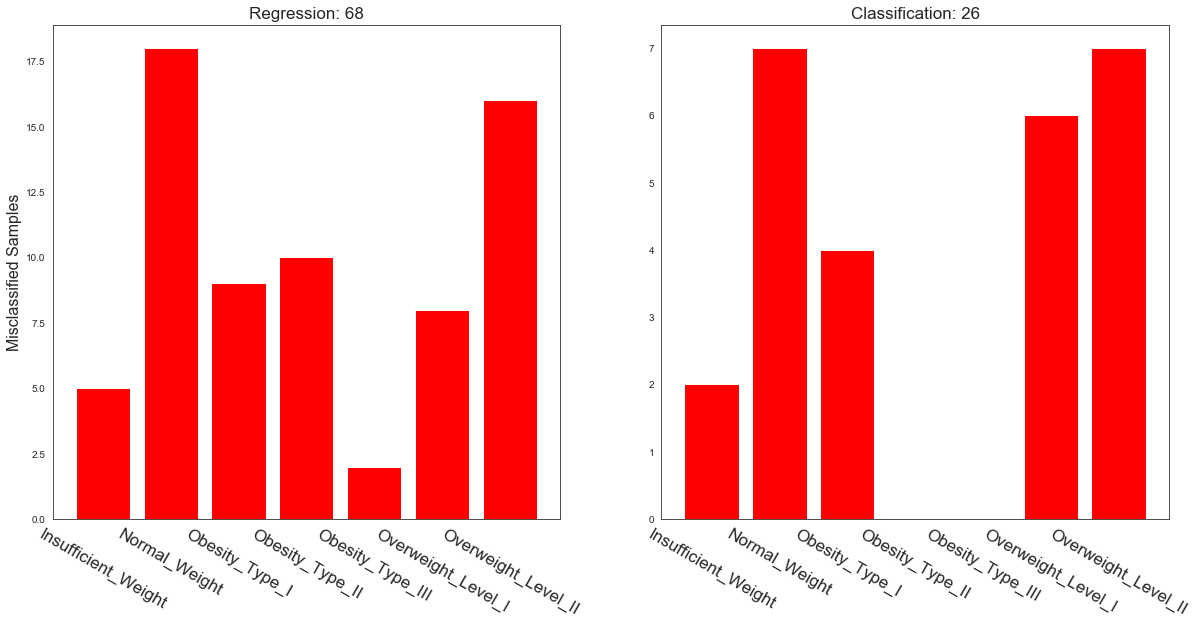

In [155]:
# graphing the missclasified samples for each model

plt.figure(figsize=(20, 20))

# Logistic Regression
plt.subplot(221)

plt.bar(height=class_false['regr_false'], x=class_false.index, color='red')
plt.ylabel('Misclassified Samples', fontsize=16)
plt.xticks(rotation=-30, fontsize=17)
pred_lr_ms_sum = class_false['regr_false'].sum().astype(int)
plt.title(f'Regression: {pred_lr_ms_sum}', fontsize=17)

# Decision Tree
plt.subplot(222)

plt.bar(height = class_false['class_false'], x=class_false.index, color='red')
pred_dt_ms_sum = class_false['class_false'].sum().astype(int)
plt.xticks(rotation=-30, fontsize=17)
plt.title(f'Classification: {pred_dt_ms_sum}', fontsize=17)

plt.show()

In [44]:
# check_is_fitted(lb, 'Yes', 'The tfidf vector is not fitted')

# try:
#     check_is_fitted(vectorizer, '_tfidf', 'The tfidf vector is not fitted')
# except NotFittedError:
#     print('asd')



# def model_fitted(model):
#     return 0 < len( [k for k,v in inspect.getmembers(model) if k.endswith('_') and not k.startswith('__')] )

# def label_encoder(objective,process):

#     try:
#       lbl_enc
#     except NameError:
#       lbl_enc = LabelEncoder()
    
#     if model_fitted(lbl_enc)==0:
        
#         lbl_enc.fit(objective)
    
#         result = 'Model Has Been Fitted'
    
#     else:
        
#         if process=='transform':
        
#             result = lbl_enc.transform(objective)
        
#         elif process=='inverse':
            
#             result = lbl_enc.inverse_transform(objective)
#         else:
            
#             result = 'Put a valid value for process'
    
#     return result


print(my_inspector(lb)) 

NameError: name 'my_inspector' is not defined